<a href="https://colab.research.google.com/github/Conor-Luppnow/Aromaticity-Classification/blob/master/FinalProj3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Code to install necessary libraries and perform authorization

"""
When you run this code, you will be asked to authenticate which can be done by 
clicking the click outputed and copy pasting the access code. Sometime you have to do this couple of time to gain access

If you ran this code after successful authentication during your session,
when asked for verification code without any link to browser, enter your google password
"""

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
··········


In [2]:
## Mount google drive 

!mkdir -p drive 
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
## Create a folder called "testing"(any name you want )

## Setting the working directory
import os
os.chdir("drive/Colab_Notebooks/Project3")

In [4]:
!pip install tensorflow-gpu==1.15

In [0]:

import cv2                 
                
from random import shuffle 
from tqdm import tqdm      

train_directory = '/content/drive/Colab_Notebooks/Project3/batch_2_train'
IMG_SIZE = 300 # all my images are 300x300






In [0]:
def label_img(img):
    #word_label = img.split('.')[-3] # all my names have "ya.<cid> or na.<cid>" where na is not aromatic and ya is aromatic, the CID is just a number from where I got the data
    if "na." in img: return [1,0]
    #if word_label == 'na': return [1,0] # not aromatic
    elif "ya." in img: return[0,1]                       
    #elif word_label == 'ya': return [0,1] # aromatic

In [0]:
def create_train_data():
    training_data = []
    try:
      for img in tqdm(os.listdir(train_directory)):
        label = label_img(img)
        path = os.path.join(train_directory,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    except Exception as e:
        print(str(e))
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

    

In [0]:
import numpy as np

In [0]:
train_data = create_train_data()


100%|██████████| 1217/1217 [07:58<00:00,  2.54it/s]


In [0]:
train_data = np.load('train_data.npy',allow_pickle=True)

In [9]:

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
model = tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=5, padding="same",input_shape=(300, 300, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, kernel_size=3, padding="same", activation = 'relu'))
model.add(Conv2D(128, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, kernel_size=3, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(32, kernel_size=3, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'  ))
model.add(Dropout(0.1))

model.add(Dense(units=256, activation='relu'  ))
model.add(Dropout(0.1))

model.add(Dense(2))
model.add(Activation("softmax"))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
a= len(train_data)
print(a)
b = len(train_data)*.7
print(b)

1217
851.9


In [0]:

train = train_data[:970]
test = train_data[971:]

In [11]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y = [i[1] for i in train]

from keras.utils import to_categorical
y=np.array(y)


x_test = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_test = [i[1] for i in test]

y_test = np.array(y_test)



Using TensorFlow backend.


In [13]:
print(X.shape)
print(y.shape)


(970, 300, 300, 1)
(970, 2)


In [0]:
from keras.callbacks import ModelCheckpoint
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
#Compile the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 73, 73, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0

In [17]:
#Input the training data and the validation data
#Also save the history for looking at the model over epochs
hist = model.fit(X, y, epochs=20, batch_size=60,verbose=1, validation_data = (x_test, y_test), validation_steps=5, callbacks=callbacks_list)

Train on 970 samples, validate on 246 samples
Epoch 1/20
960/970 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.9125
Epoch 00001: val_acc improved from -inf to 0.88618, saving model to weights-improvement-01-0.8862.hdf5
970/970 [==============================] - 11s 12ms/sample - loss: 0.2586 - acc: 0.9124 - val_loss: 0.4036 - val_acc: 0.8862
Epoch 2/20
960/970 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9802
Epoch 00002: val_acc improved from 0.88618 to 0.91463, saving model to weights-improvement-02-0.9146.hdf5
970/970 [==============================] - 6s 7ms/sample - loss: 0.0883 - acc: 0.9804 - val_loss: 0.2950 - val_acc: 0.9146
Epoch 3/20
960/970 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9958
Epoch 00003: val_acc improved from 0.91463 to 0.93496, saving model to weights-improvement-03-0.9350.hdf5
970/970 [==============================] - 8s 9ms/sample - loss: 0.0248 - acc: 0.9959 - val_loss: 0.2698 - val_acc: 0.

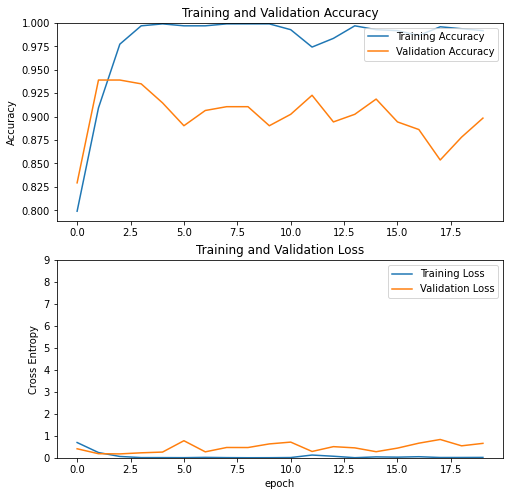

In [39]:
import matplotlib.pyplot as plt

#Plot the accuracy and loss over the epochs
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,9.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [0]:
weight_name = "weights-improvement-02-0.9390.hdf5"
model.load_weights(weight_name)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print("loss: " + str(val_loss))
print("accuracy: " + str(val_acc))

246/246 [==============================] - 0s 976us/sample - loss: 0.7348 - acc: 0.8821
loss: 0.7348478266863319
accuracy: 0.8821138


In [22]:
print("Done")

Done
